# Alcoholics Anonymous

Performing EEG analysis to detect the alcoholics!

More details regarding the dataset are available at https://archive.ics.uci.edu/ml/datasets/eeg+database


First do some magic to load the dataset!

In [13]:
!mkdir -p data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TEST.tar.gz
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TRAIN.tar.gz


--2024-10-03 14:34:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TEST.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘SMNI_CMI_TEST.tar.gz.1’

SMNI_CMI_TEST.tar.g     [            <=>     ]  37,02M  10,7MB/s    in 4,5s    

2024-10-03 14:34:36 (8,27 MB/s) - ‘SMNI_CMI_TEST.tar.gz.1’ saved [38815160]

--2024-10-03 14:34:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/eeg-mld/SMNI_CMI_TRAIN.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘SMNI_CMI_TRAIN.tar.gz.1’

SMNI_CMI_TRAIN.tar.     [             <=>    ]  36,71M  10,5MB/s    in 4,5s    

2024-10

In [15]:
!tar zxf SMNI_CMI_TRAIN.tar.gz -C data
!tar zxf SMNI_CMI_TEST.tar.gz -C data

Define the loading functions:


In [16]:
from os.path import isfile, isdir, join
from os import listdir
import gzip
import numpy as np
import pickle
from os.path import exists


def extract_data(train_path='data/SMNI_CMI_TRAIN', test_path='data/SMNI_CMI_TEST'):
    """
    Transforms the EEG dataset into the appropriate format
    :param train_path:
    :param test_path:
    :return:
    """

    def load_from_folder(path):
        files = [join(path, x) for x in listdir(path) if isfile(join(path, x)) and x[-3:] == '.gz']
        eeg_data = []
        for file_path in files:
            cfile = gzip.open(file_path, 'r')
            lines = cfile.readlines()
            cfile.close()
            data = lines[4:]
            data = [x for i, x in enumerate(data) if np.mod(i, 257) != 0]

            values = np.float32([float(x.split()[3]) for x in data]).reshape((64, 256))
            eeg_data.append(values)
        eeg_data = np.float32(eeg_data)
        return eeg_data

    print("Preprocessing the dataset...")
    data = []
    labels = []
    for folder in listdir(train_path):
        if isdir(join(train_path, folder)):
            data.append(load_from_folder(join(train_path, folder)))
            if folder[3] == 'a':
                labels.append(np.ones((data[-1].shape[0],)))
            else:
                labels.append(0 * np.ones((data[-1].shape[0],)))
    train_data = np.float32(np.concatenate(data))
    train_labels = np.float32(np.concatenate(labels))

    data = []
    labels = []
    for folder in listdir(test_path):
        if isdir(join(test_path, folder)):
            data.append(load_from_folder(join(test_path, folder)))
            if folder[3] == 'a':
                labels.append(np.ones((data[-1].shape[0],)))
            else:
                labels.append(0 * np.ones((data[-1].shape[0],)))
    test_data = np.float32(np.concatenate(data))
    test_labels = np.float32(np.concatenate(labels))

    with open('data/dataset.pickle', 'wb') as f:
        pickle.dump(train_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_labels, f, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(test_data, f, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(test_labels, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_dataset():
    """
    Loads the EEG dataset
    :return:
    """

    if not exists('data/dataset.pickle'):
        extract_data()

    with open('data/dataset.pickle', 'rb') as f:
        train_data = pickle.load(f)
        train_labels = pickle.load(f)
        test_data = pickle.load(f)
        test_labels = pickle.load(f)

    return train_data, train_labels, test_data, test_labels

Now, we are ready to load the data!

In [17]:
X_train, y_train, X_test, y_test = load_dataset()

In [18]:
X_train = X_train.transpose((0, 2, 1))
X_test = X_test.transpose((0, 2, 1))

print(X_train.shape, X_test.shape)

(600, 256, 64) (600, 256, 64)


Let's visualize an EEG!

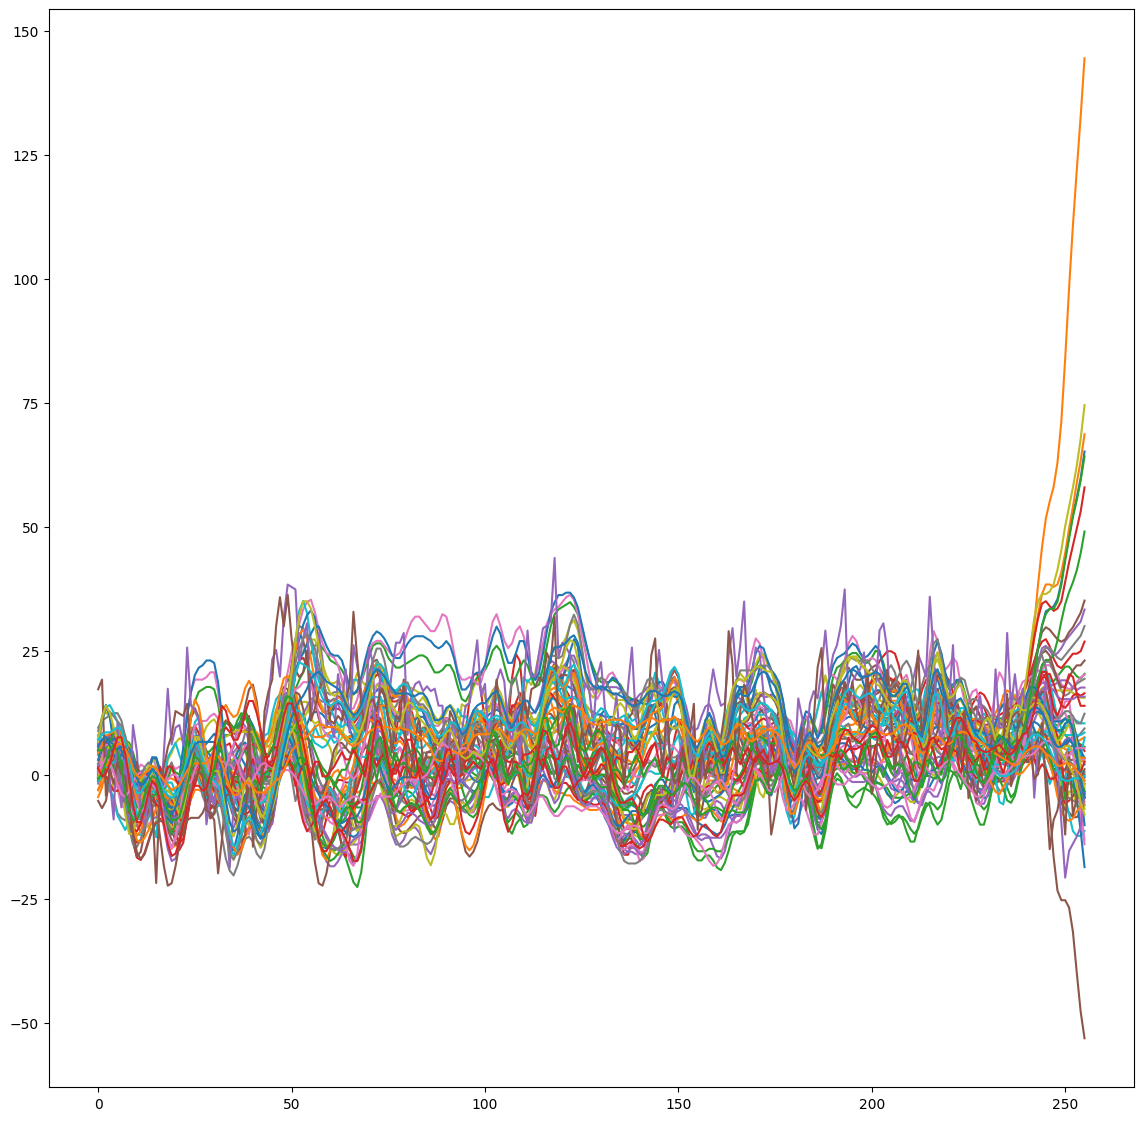

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(14, 14))
for i in range(64):
    plt.plot(X_train[0, :, i])


Standard scaling works quite well for this dataset!

In [20]:
from sklearn.preprocessing import StandardScaler
def scale_data(train_data, test_data):

    data = train_data.reshape((-1, train_data.shape[2]))
    scaler = StandardScaler()
    scaler.fit(data)

    # Scale the training data
    for i in range(train_data.shape[0]):
        train_data[i] = scaler.transform(train_data[i])

    # Scale the training data
    for i in range(test_data.shape[0]):
        test_data[i] = scaler.transform(test_data[i])

    return train_data, test_data


In [21]:
X_train, X_test = scale_data(X_train, X_test)

### MLP Classifer


Flatten the data first!

In [22]:
X_train_mlp = X_train.reshape((-1, 64 * 256))
X_test_mlp  = X_test.reshape((-1, 64 * 256))

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical


model = Sequential()
model.add(Dense(512, input_dim=64 * 256))
model.add(Activation('tanh'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_mlp, to_categorical(y_train), batch_size=32, epochs=30, verbose=0)
train_score, train_acc = model.evaluate(X_train_mlp, to_categorical(y_train), batch_size=32, verbose=0)
test_score, test_acc = model.evaluate(X_test_mlp, to_categorical(y_test), batch_size=32, verbose=0)
print ("Train acc, test acc = ", 100*train_acc, ", ", 100*test_acc)

Train acc, test acc =  99.6666669845581 ,  76.49999856948853


### Something quite simple, but smart!


We are looking for certain patterns in the input signal. We can use a "Bag-of-Features" approach to quantize the data and then build a histogram.

In [26]:
from keras.layers import Conv1D, GlobalAveragePooling1D

model = Sequential()

# Quantize the input features (BoF-like)
model.add(Conv1D(32, 1, input_shape=(256, 64)))
model.add(Activation('softmax'))
model.add(GlobalAveragePooling1D())

model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, to_categorical(y_train), batch_size=32, epochs=30, verbose=0)
train_score, train_acc = model.evaluate(X_train, to_categorical(y_train), batch_size=32, verbose=0)
test_score, test_acc = model.evaluate(X_test, to_categorical(y_test), batch_size=32, verbose=0)
print ("Train acc, test acc = ", 100*train_acc, ", ", 100*test_acc)

Train acc, test acc =  95.6666648387909 ,  87.00000047683716
